Calculate input proportion (i.e. inprop, normalised connectivity) for right optic lobe, and the entire central brain of FAFB on a signle neuron level. All cells that only have connectivity on the left optic lobe are removed. Input proportion are calculated using the total number of post-synapses each neuron has, regardless of where the connections are (central brain or optic lobe). 

In [1]:
import pandas as pd
import numpy as np
from scipy.sparse import coo_matrix
import scipy as sp
import matplotlib.pyplot as plt

In [2]:
chosen_side = "right"
side_first_letter = "R"

# reading data

In [3]:
info = pd.read_csv(
    "https://raw.githubusercontent.com/flyconnectome/flywire_annotations/main/supplemental_files/Supplemental_file1_neuron_annotations.tsv",
    delimiter="\t",
)
info.columns

C:\Users\44745\AppData\Local\Temp\ipykernel_584\2178494025.py:1: DtypeWarning: Columns (14,15,16,17,23) have mixed types. Specify dtype option on import or set low_memory=False.
  info = pd.read_csv(


Index(['supervoxel_id', 'root_id', 'pos_x', 'pos_y', 'pos_z', 'soma_x',
       'soma_y', 'soma_z', 'nucleus_id', 'flow', 'super_class', 'cell_class',
       'cell_sub_class', 'cell_type', 'hemibrain_type', 'ito_lee_hemilineage',
       'hartenstein_hemilineage', 'morphology_group', 'top_nt', 'top_nt_conf',
       'known_nt', 'known_nt_source', 'side', 'nerve', 'vfb_id', 'fbbt_id',
       'status'],
      dtype='object')

In [4]:
info.super_class.value_counts(dropna=False)

super_class
optic                 77536
central               32388
sensory               16903
visual_projection      8053
ascending              2362
descending             1303
visual_centrifugal      524
motor                   106
endocrine                80
Name: count, dtype: int64

## make combined cell type

In [5]:
# where are the cell types?
info[["cell_type", "hemibrain_type"]].isna().value_counts()

cell_type  hemibrain_type
False      True              102047
True       False              20721
False      False               9043
True       True                7444
Name: count, dtype: int64

In [6]:
# around 3k with both cell_type and hemibrain_type - do they correspond to each other?
info[~info.cell_type.isna() & ~info.hemibrain_type.isna()][
    ["cell_type", "hemibrain_type"]
].value_counts()

cell_type   hemibrain_type                                                         
KCab        KCab-s                                                                     621
            KCab-m                                                                     619
            KCab-c                                                                     403
KCapbp-m    KCa'b'-m                                                                   338
KCapbp-ap2  KCa'b'-ap2                                                                 298
                                                                                      ... 
LCe01b      LC25                                                                         1
            LC25,LC26                                                                    1
CB.FB3,4I1  FB4A,FB4D,FB4E,FB4F,FB4G,FB4H,FB4I,FB4J                                      1
CB.FB3,4D4  FB5X                                                                         1
vDelta

In [7]:
# since hemibrain is truncated, let's prioritize cell_type
info.loc[:, ["combined_type"]] = info.cell_type
# fill the leftover nas with hemibrain_type
info.combined_type.fillna(info.hemibrain_type, inplace=True)
# then fill the rest with root ids
info.combined_type.fillna(info.root_id.astype(str), inplace=True)

In [8]:
# make dictionaries to map between columns
typedict = dict(zip(info.root_id, info.combined_type))
sidedict = dict(zip(info.root_id, info.side))
type_super_class_dict = dict(zip(info.combined_type, info.super_class))
type_class_dict = dict(zip(info.combined_type, info.cell_class))
type_sub_class_dict = dict(zip(info.combined_type, info.cell_sub_class))

## read connectivity
Courtesy of Dr Sven Dorkenwald: https://zenodo.org/records/10676866

In [9]:
# this can take a minute or two
from io import BytesIO
import requests

url = "https://zenodo.org/records/10676866/files/proofread_connections_783.feather"

# Download the file
response = requests.get(url)

# Use the file content directly in Python
file_content = response.content

conn_full = pd.read_feather(BytesIO(file_content))
conn_full

,pre_pt_root_id,post_pt_root_id,neuropil,syn_count,gaba_avg,ach_avg,glut_avg,oct_avg,ser_avg,da_avg
0,720575940629970489,720575940631267655,AVLP_R,7,0.654330,0.023704,2.724177e-01,4.812546e-02,4.724386e-04,0.000951
1,720575940623828999,720575940612348950,SLP_R,4,0.386517,0.024020,5.805122e-01,8.166312e-04,8.567505e-04,0.007278
2,720575940624078484,720575940616950161,SMP_R,2,0.001719,0.979256,1.810526e-03,1.633383e-05,5.870429e-03,0.011328
3,720575940629583345,720575940620324735,SMP_L,2,0.011815,0.031954,4.729873e-01,9.134340e-03,8.697341e-02,0.387136
4,720575940605876866,720575940606514878,LAL_R,15,0.994271,0.005063,5.223293e-04,3.998458e-07,1.034742e-04,0.000040
...,...,...,...,...,...,...,...,...,...,...
16847992,720575940615769750,720575940622822680,AVLP_L,1,0.004619,0.896132,3.206258e-02,1.844075e-03,2.894549e-02,0.036396
16847993,720575940624016823,720575940622760993,ME_R,4,0.080482,0.536168,2.336121e-02,3.442164e-01,2.744474e-04,0.015498
16847994,720575940637397309,720575940633255123,SLP_R,2,0.987325,0.008161,4.205040e-03,8.760364e-06,2.006123e-05,0.000281
16847995,720575940636432014,720575940617470681,ME_R,1,0.026646,0.031076,9.088086e-01,4.470230e-03,1.418527e-02,0.014815


In [10]:
conn_full.loc[:, ["pre_type"]] = conn_full.pre_pt_root_id.map(typedict)
conn_full.loc[:, ["post_type"]] = conn_full.post_pt_root_id.map(typedict)
conn_full.loc[:, ["pre_side"]] = conn_full.pre_pt_root_id.map(sidedict)
conn_full.loc[:, ["post_side"]] = conn_full.post_pt_root_id.map(sidedict)
conn_full.loc[:, ["pre_super_class"]] = conn_full.pre_type.map(
    type_super_class_dict
)
conn_full.loc[:, ["post_super_class"]] = conn_full.post_type.map(
    type_super_class_dict
)
conn_full

,pre_pt_root_id,post_pt_root_id,neuropil,syn_count,gaba_avg,ach_avg,glut_avg,oct_avg,ser_avg,da_avg,pre_type,post_type,pre_side,post_side,pre_super_class,post_super_class
0,720575940629970489,720575940631267655,AVLP_R,7,0.654330,0.023704,2.724177e-01,4.812546e-02,4.724386e-04,0.000951,PLP017,CB3488,right,right,central,central
1,720575940623828999,720575940612348950,SLP_R,4,0.386517,0.024020,5.805122e-01,8.166312e-04,8.567505e-04,0.007278,LHPV6p1,AVLP314,right,right,central,central
2,720575940624078484,720575940616950161,SMP_R,2,0.001719,0.979256,1.810526e-03,1.633383e-05,5.870429e-03,0.011328,CB0960,CB0710,left,right,central,central
3,720575940629583345,720575940620324735,SMP_L,2,0.011815,0.031954,4.729873e-01,9.134340e-03,8.697341e-02,0.387136,CB0960,CB2317,left,left,central,central
4,720575940605876866,720575940606514878,LAL_R,15,0.994271,0.005063,5.223293e-04,3.998458e-07,1.034742e-04,0.000040,LAL138,CB2018,left,right,central,central
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16847992,720575940615769750,720575940622822680,AVLP_L,1,0.004619,0.896132,3.206258e-02,1.844075e-03,2.894549e-02,0.036396,PVLP007,AVLP089,left,left,central,central
16847993,720575940624016823,720575940622760993,ME_R,4,0.080482,0.536168,2.336121e-02,3.442164e-01,2.744474e-04,0.015498,CB3816,TmY4,right,right,optic,optic
16847994,720575940637397309,720575940633255123,SLP_R,2,0.987325,0.008161,4.205040e-03,8.760364e-06,2.006123e-05,0.000281,CB2036,CB1594,right,right,central,central
16847995,720575940636432014,720575940617470681,ME_R,1,0.026646,0.031076,9.088086e-01,4.470230e-03,1.418527e-02,0.014815,Mi14,Tm2,right,right,optic,optic


# selection
Remove all connections in left optic lobe, then we should be left with neurons with connections in the central brain / right optic lobe

## unassigned

In [11]:
# unassigned
unasgd = conn_full[conn_full.neuropil == "UNASGD"]
unasgd.pre_type.value_counts()

pre_type
C2                    359
R8                    174
R7                    169
T1                    111
Tm3                    54
                     ... 
PLP182                  1
AN_GNG_110              1
CB3821                  1
720575940604971488      1
MBON09                  1
Name: count, Length: 557, dtype: int64

In [12]:
unasgd.shape[0]

3193

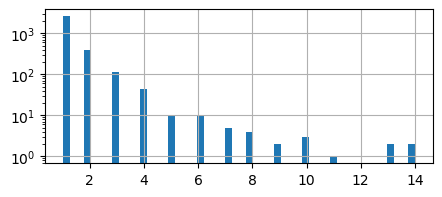

In [13]:
unasgd.syn_count.hist(bins=50, figsize=(5, 2))
plt.yscale("log")

In [14]:
unasgd.loc[
    (unasgd.pre_super_class == "optic") & (unasgd.post_super_class == "optic"),
    ["pre_side", "post_side"],
].value_counts()

pre_side  post_side
left      left         989
right     right        722
left      right          1
Name: count, dtype: int64

In [15]:
unasgd.loc[
    (unasgd.pre_side == "left") & (unasgd.post_side == "left"),
    ["pre_super_class", "post_super_class"],
].value_counts()

pre_super_class     post_super_class  
optic               optic                 989
sensory             optic                 163
                    sensory               144
central             central               100
optic               sensory                42
visual_projection   optic                  27
optic               visual_projection      25
visual_projection   visual_projection      24
central             visual_projection      17
ascending           central                15
descending          descending             12
                    central                10
ascending           ascending              10
central             sensory                10
ascending           descending              9
central             descending              8
                    motor                   7
descending          ascending               6
central             optic                   6
visual_projection   visual_centrifugal      5
visual_centrifugal  optic                

Remove optic-optic connections on the left, and remove connections with R1-6, R7 & R8. 

In [16]:
unasgd_kept = unasgd[
    (
        ~(
            (unasgd.pre_side == "left")
            & (unasgd.post_side == "left")  # Not: on the left and
            &
            # optic-optic connections
            (unasgd.pre_super_class == "optic")
            & (unasgd.post_super_class == "optic")
        )
    )
    &
    # and not: on the left and
    (
        ~(
            (unasgd.pre_side == "left") & (unasgd.post_side == "left") &
            # receptor connections
            (unasgd.pre_type.isin(["R1-6", "R7", "R8"]))
            | (unasgd.post_type.isin(["R1-6", "R7", "R8"]))
        )
    )
]
unasgd_kept

,pre_pt_root_id,post_pt_root_id,neuropil,syn_count,gaba_avg,ach_avg,glut_avg,oct_avg,ser_avg,da_avg,pre_type,post_type,pre_side,post_side,pre_super_class,post_super_class
4200,720575940647380276,720575940616894235,UNASGD,1,0.305237,0.513160,0.035601,0.021487,0.060903,0.063612,Tm6,Tm3,right,right,optic,optic
17175,720575940625438138,720575940616746845,UNASGD,1,0.054615,0.770166,0.001180,0.007931,0.080973,0.085136,T1,Tm1,right,right,optic,optic
51430,720575940618819974,720575940616389789,UNASGD,1,0.078838,0.072122,0.030518,0.285334,0.038008,0.495180,T1,Tm3,right,right,optic,optic
87457,720575940656152737,720575940624390438,UNASGD,2,0.533593,0.110529,0.071253,0.015382,0.007922,0.261321,TmY18,Dm12,right,right,optic,optic
92652,720575940604764862,720575940637531369,UNASGD,1,0.215350,0.170930,0.257649,0.032816,0.027288,0.295966,CB3312,CB1951,left,left,central,central
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16786087,720575940612378610,720575940632952204,UNASGD,1,0.111784,0.158423,0.041776,0.017298,0.027291,0.643428,Tm2,T1,right,right,optic,optic
16786450,720575940610964946,720575940613166515,UNASGD,1,0.027977,0.018395,0.012440,0.002934,0.015075,0.923179,MBON09,SMP172,right,right,central,central
16804175,720575940638579107,720575940620741205,UNASGD,1,0.047019,0.314381,0.079054,0.007220,0.080528,0.471797,MTe53,aMe1,left,left,visual_projection,visual_projection
16818796,720575940613639395,720575940616527484,UNASGD,1,0.450000,0.147061,0.003466,0.240975,0.071056,0.087442,Mi15,720575940616527484,right,right,optic,optic


## rest

In [17]:
conn_full.neuropil.unique()

array(['AVLP_R', 'SLP_R', 'SMP_R', 'SMP_L', 'LAL_R', 'AL_L', 'SIP_R',
       'AVLP_L', 'AOTU_L', 'LA_R', 'MB_ML_R', 'CRE_L', 'GNG', 'CRE_R',
       'EB', 'PRW', 'MB_ML_L', 'AL_R', 'MB_VL_R', 'MB_VL_L', 'GA_L',
       'GA_R', 'AOTU_R', 'FLA_R', 'LAL_L', 'FLA_L', 'MB_PED_R', 'SAD',
       'AMMC_R', 'SIP_L', 'PVLP_R', 'MB_PED_L', 'UNASGD', 'AMMC_L',
       'LO_L', 'ME_R', 'LOP_L', 'LO_R', 'PLP_R', 'SCL_L', 'ME_L', 'LOP_R',
       'LH_L', 'VES_R', 'LH_R', 'MB_CA_L', 'IPS_L', 'SLP_L', 'PLP_L',
       'SPS_L', 'IPS_R', 'GOR_R', 'FB', 'SPS_R', 'PVLP_L', 'ICL_L',
       'SCL_R', 'ICL_R', 'ATL_R', 'IB_R', 'NO', 'AME_L', 'VES_L', 'WED_L',
       'MB_CA_R', 'WED_R', 'LA_L', 'ATL_L', 'EPA_R', 'PB', 'IB_L',
       'EPA_L', 'GOR_L', 'CAN_R', 'AME_R', 'OCG', 'CAN_L', 'BU_R', 'BU_L'],
      dtype=object)

In [18]:
conn = conn_full[
    ~conn_full.neuropil.isin(["UNASGD", "ME_L", "LO_L", "LOP_L", "LA_L"])
]
conn = pd.concat([conn, unasgd_kept])
conn

,pre_pt_root_id,post_pt_root_id,neuropil,syn_count,gaba_avg,ach_avg,glut_avg,oct_avg,ser_avg,da_avg,pre_type,post_type,pre_side,post_side,pre_super_class,post_super_class
0,720575940629970489,720575940631267655,AVLP_R,7,0.654330,0.023704,0.272418,4.812546e-02,0.000472,0.000951,PLP017,CB3488,right,right,central,central
1,720575940623828999,720575940612348950,SLP_R,4,0.386517,0.024020,0.580512,8.166312e-04,0.000857,0.007278,LHPV6p1,AVLP314,right,right,central,central
2,720575940624078484,720575940616950161,SMP_R,2,0.001719,0.979256,0.001811,1.633383e-05,0.005870,0.011328,CB0960,CB0710,left,right,central,central
3,720575940629583345,720575940620324735,SMP_L,2,0.011815,0.031954,0.472987,9.134340e-03,0.086973,0.387136,CB0960,CB2317,left,left,central,central
4,720575940605876866,720575940606514878,LAL_R,15,0.994271,0.005063,0.000522,3.998458e-07,0.000103,0.000040,LAL138,CB2018,left,right,central,central
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16786087,720575940612378610,720575940632952204,UNASGD,1,0.111784,0.158423,0.041776,1.729788e-02,0.027291,0.643428,Tm2,T1,right,right,optic,optic
16786450,720575940610964946,720575940613166515,UNASGD,1,0.027977,0.018395,0.012440,2.933712e-03,0.015075,0.923179,MBON09,SMP172,right,right,central,central
16804175,720575940638579107,720575940620741205,UNASGD,1,0.047019,0.314381,0.079054,7.220198e-03,0.080528,0.471797,MTe53,aMe1,left,left,visual_projection,visual_projection
16818796,720575940613639395,720575940616527484,UNASGD,1,0.450000,0.147061,0.003466,2.409754e-01,0.071056,0.087442,Mi15,720575940616527484,right,right,optic,optic


In [19]:
allids = set(conn.pre_pt_root_id) & set(conn.post_pt_root_id)
len(allids)

93493

In [20]:
# check to make sure
meta = info[info.root_id.isin(allids)]

In [21]:
meta[meta.cell_class == "visual"].side.value_counts()

side
right     4741
left        90
center      76
Name: count, dtype: int64

In [22]:
meta[meta.super_class == "optic"].side.value_counts()

side
right    38455
left       313
Name: count, dtype: int64

In [23]:
meta[
    (meta.super_class == "optic") & (meta.side == "left")
].cell_type.value_counts()

cell_type
CB3833         36
LC14b          20
LC14a1         15
CB3822         11
LC14a2         11
CB3818          9
T2a             8
Pm2             7
MeMe_e01        7
CB3820          6
CB3821          4
CB3819          4
CB3828          4
Mi1             3
CB3834          3
CB3836          3
MeMe_e10        2
Tm1             2
CB3823          2
Tm3             2
MeMe_e11        2
C2              2
Pm1             2
Tm6             2
Pm1a            2
Pm4             1
LPT45_dCal1     1
Dm17            1
CB3843          1
Pm13            1
Mi2             1
TmYem1          1
CB3829          1
CB3856          1
T2              1
Mi14            1
CB3842          1
T3              1
Y3              1
CB3824          1
MeMe_e12        1
TmY16           1
MeMe_e13        1
MeLp2           1
CB3827          1
Tm4             1
Tm16            1
Tm20            1
MeMe_e09        1
TmY5a           1
TmY18           1
CB3835          1
CB3815          1
Mt4             1
Dm2             1


In [24]:
# number of GB
len(allids) ** 2 * 4 / 1e9

34.963764196

# NT

In [25]:
meta.top_nt.value_counts(dropna=False)

top_nt
acetylcholine    56255
glutamate        17367
gaba             12025
dopamine          5868
serotonin         1826
octopamine         152
Name: count, dtype: int64

In [26]:
meta.known_nt.unique()

array([nan, 'acetylcholine', 'DILP2, DILP3, DILP5', 'glutamate',
       'glutamate, sparkly, proctolin, Nplp1',
       'dopamine, sparkly, Nplp1, amnesiac, CG43117, ion-transport peptide, nitric oxide',
       'gaba', 'acetylcholine, Nplp1, sNPF, sparkly',
       'glutamate, Dh44, allatostatin-c', 'dopamine',
       'acetylcholine, sNPF, sparkly', 'Dh44', 'octopamine',
       'acetylcholine, sparkly',
       'dopamine, amnesiac, sparkly, Nplp1, CG34136, sNPF', 'CCHa2R',
       'Drosulfakinin', 'gaba, myoinhibitory peptide',
       'dopamine, Nplp1, sNPF, sparkly, amnesiac, CG34136',
       'dopamine, amnesiac, sparkly, Dh44, CG34136, Nplp1',
       'allatostatin-a, glutamate', 'CCHa1, Dh44, glutamate',
       'dopamine, amnesiac, sparkly, pdf, Gpb5', 'Dh31',
       'acetylcholine, space blanket',
       'gaba, serotonin, sparkly, Nplp1, proctolin, orcokinin, eclosion hormone, CG34136',
       'serotonin', 'glycine, pdf', 'dopamine, nitric oxide',
       'glutamate, leucokinin', 'corazo

In [27]:
# known_nt takes priority
meta["known_nt_simplified"] = meta.known_nt
# pattern matching: only keep if value contains 'glutamate', 'gaba', or 'acetylcholine'
meta.known_nt_simplified = meta.known_nt_simplified.str.extract(
    "(glutamate|gaba|acetylcholine)", expand=False
)
# note that if a value has multiple matches, only the first one is kept
# e.g. 'glutamate, gaba' will be simplified to 'glutamate'
meta.known_nt_simplified.value_counts(dropna=False)

# then use this column to replace values in top_nt column
meta.top_nt = meta.known_nt_simplified.fillna(meta.top_nt)

C:\Users\44745\AppData\Local\Temp\ipykernel_584\316772857.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meta["known_nt_simplified"] = meta.known_nt
C:\Users\44745\AppData\Local\Temp\ipykernel_584\316772857.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meta.known_nt_simplified = meta.known_nt_simplified.str.extract(
C:\Users\44745\AppData\Local\Temp\ipykernel_584\316772857.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

C:\Users\44745\AppData\Local\Temp\ipykernel_584\4061033137.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meta["top_nt"] = meta["top_nt"].fillna("unknown")


(array([1.2046e+04, 0.0000e+00, 5.2500e+02, 0.0000e+00, 6.2000e+01,
        0.0000e+00, 1.2000e+01, 0.0000e+00, 4.0000e+00, 5.0000e+00]),
 array([1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. , 5.5, 6. ]),
 <BarContainer object of 10 artists>)

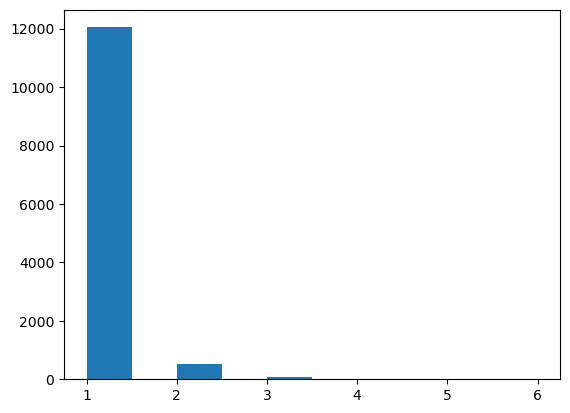

In [28]:
# first check consistency of NT within each type
meta["top_nt"] = meta["top_nt"].fillna("unknown")
nt_count_per_type = meta.groupby("combined_type")["top_nt"].nunique()
plt.hist(nt_count_per_type)

In [29]:
# For those with different NT for each neuron, get the majority NT for each type
nt_conflict_types = nt_count_per_type[nt_count_per_type > 1].index

# Getting counts of top_nt for each combined_type
nt_conflict_type_counts = (
    meta[meta.combined_type.isin(nt_conflict_types)]
    .groupby(["combined_type", "top_nt"])
    .size()
)

# Convert the series to a DataFrame and reset index
nt_conflict_type_counts = nt_conflict_type_counts.reset_index(name="counts")

# Sort by combined_type and counts in descending order
nt_conflict_type_counts.sort_values(
    by=["combined_type", "counts"], ascending=[True, False], inplace=True
)

# Initialize dictionary with existing type-nt matching
type_nt = dict(zip(meta.combined_type, meta.top_nt))
# Initialize a list to keep track of types with equal top_nt counts
types_with_equal_top_nt_counts = []


# Custom function to handle ties, random selection, and record keeping
def select_random_nt_and_record_ties(df):
    max_count = df["counts"].max()
    top_nts = df[df["counts"] == max_count]
    if len(top_nts) > 1:  # If there are ties
        types_with_equal_top_nt_counts.append(
            df["combined_type"].iloc[0]
        )  # Record the type with ties
        random_nt = np.random.choice(top_nts["top_nt"].values)
        while random_nt == "unknown":
            random_nt = np.random.choice(top_nts["top_nt"].values)
        return random_nt  # Random selection among ties
    else:
        return top_nts["top_nt"].values[0]


# Loop through each type to get the top_nt, handling ties appropriately
for atype in nt_conflict_types:
    type_df = nt_conflict_type_counts[
        nt_conflict_type_counts["combined_type"] == atype
    ]
    top_nt = select_random_nt_and_record_ties(type_df)
    type_nt[atype] = top_nt

len(types_with_equal_top_nt_counts)

224

In [30]:
types_with_equal_top_nt_counts

['5-HTPMPV01',
 'AL-MBDL1',
 'ALBN1',
 'AN_AVLP_38',
 'AN_AVLP_GNG_12',
 'AN_FLA_GNG_2',
 'AN_GNG_102',
 'AN_GNG_106',
 'AN_GNG_116',
 'AN_GNG_121',
 'AN_GNG_123',
 'AN_GNG_125',
 'AN_GNG_137',
 'AN_GNG_177',
 'AN_GNG_20',
 'AN_GNG_202',
 'AN_GNG_204',
 'AN_GNG_31',
 'AN_GNG_34',
 'AN_GNG_48',
 'AN_GNG_62',
 'AN_GNG_77',
 'AN_GNG_90',
 'AN_GNG_95',
 'AN_GNG_IPS_1',
 'AN_GNG_IPS_5',
 'AN_GNG_PRW_3',
 'AN_GNG_SAD_7',
 'AN_IPS_GNG_1',
 'AN_IPS_GNG_5',
 'AN_SAD_FLA_1',
 'AN_SLP_AVLP_1',
 'AN_SMP_3',
 'AN_SMP_FLA_1',
 'AN_multi_11',
 'AN_multi_77',
 'AN_multi_87',
 'AN_multi_89',
 'AOTU024',
 'AOTU036',
 'ATL021',
 'ATL030',
 'ATL034',
 'AVLP031',
 'AVLP048',
 'AVLP155',
 'AVLP213',
 'AVLP215',
 'AVLP219a',
 'AVLP394',
 'BM_dOcci',
 'CAPA',
 'CB.FB3,4I2',
 'CB.FB3,4I8',
 'CB.FB6C3',
 'CB.FB6I1',
 'CB0019',
 'CB0034',
 'CB0090',
 'CB0124',
 'CB0155',
 'CB0176',
 'CB0189',
 'CB0224',
 'CB0235',
 'CB0262',
 'CB0265',
 'CB0279',
 'CB0289',
 'CB0369',
 'CB0446',
 'CB0448',
 'CB0454',
 'CB0469',


In [31]:
# the types without any known nt
[atype for atype, nt in type_nt.items() if nt == "unknown"]

[]

In [32]:
# update the top_nt column to be consistent within each type
meta.loc[:, ["top_nt"]] = meta.combined_type.map(type_nt)
meta

,supervoxel_id,root_id,pos_x,pos_y,pos_z,soma_x,soma_y,soma_z,nucleus_id,flow,...,top_nt_conf,known_nt,known_nt_source,side,nerve,vfb_id,fbbt_id,status,combined_type,known_nt_simplified
0,78112261444987077,720575940628857210,109306,50491,3960,104904.0,47464.0,5461.0,2453924.0,intrinsic,...,0.917977,NaN,NaN,left,NaN,fw138205,FBbt_20001935,NaN,PS180,NaN
1,82475466912542440,720575940626838909,172029,55635,1592,177472.0,56936.0,1429.0,7393349.0,intrinsic,...,0.645442,NaN,NaN,right,NaN,fw000001,NaN,NaN,CB0924,NaN
2,83038623024880664,720575940626046919,180632,58664,1925,180632.0,58664.0,1925.0,7415038.0,intrinsic,...,0.844781,NaN,NaN,right,NaN,fw000002,FBbt_20000538,NaN,AVLP429,NaN
3,79801523353604463,720575940630311383,133800,56063,1847,180728.0,61008.0,1630.0,7415013.0,intrinsic,...,0.760387,NaN,NaN,right,NaN,fw000003,FBbt_20000260,NaN,AVLP151,NaN
4,83038554439606237,720575940633370649,180496,57448,2989,180496.0,57448.0,2989.0,7415848.0,intrinsic,...,0.895458,NaN,NaN,right,NaN,fw000004,FBbt_00051248,NaN,LC27,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139250,83038485720179477,720575940618571494,181000,56672,3032,181000.0,56672.0,3032.0,7667349.0,intrinsic,...,0.909508,NaN,NaN,right,NaN,fw019880,NaN,NaN,720575940618571494,NaN
139251,81632416707449383,720575940633170572,160568,75600,4130,160568.0,75600.0,4130.0,6918265.0,intrinsic,...,0.842339,NaN,NaN,right,NaN,fw002173,NaN,outlier_bio,CB3823,NaN
139252,81702991543049294,720575940650339961,161088,79280,3677,161088.0,79280.0,3677.0,6918344.0,intrinsic,...,0.927558,NaN,NaN,right,NaN,fw010095,NaN,outlier_bio,CB3848,NaN
139253,75720205111813659,720575940619997854,74280,57640,3166,74280.0,57640.0,3166.0,1511338.0,intrinsic,...,0.897331,NaN,NaN,left,NaN,fw046509,NaN,NaN,720575940619997854,NaN


In [33]:
# for now regarding everything (ACh, Glu, GABA, Dopamine, Serotonine, ??) except for Glu and GABA to be excitatory
# first make a dictionary
nt_value = {
    "acetylcholine": 1,
    "glutamate": -1,
    "gaba": -1,
    "dopamine": 1,
    "serotonin": 1,
    "octopamine": 1,
    "unknown": 1,
}

# make coo

In [34]:
# sum synapse numbers across neuropils
conn = (
    conn.groupby(["pre_pt_root_id", "post_pt_root_id"])
    .syn_count.sum()
    .reset_index()
)
conn

,pre_pt_root_id,post_pt_root_id,syn_count
0,720575940596125868,720575940605825666,2
1,720575940596125868,720575940606217138,1
2,720575940596125868,720575940608552405,5
3,720575940596125868,720575940609975854,4
4,720575940596125868,720575940613059993,5
...,...,...,...
10896748,720575940661338497,720575940643867296,1
10896749,720575940661338497,720575940645527918,1
10896750,720575940661338497,720575940647030580,1
10896751,720575940661339777,720575940616982614,4


In [35]:
# instead of making a dense matrix based on the edgelist above, let's make a sparse one from the edgelist directly
# first make a coo matrix
nodes = set(conn.pre_pt_root_id).union(set(conn.post_pt_root_id))
sorted_nodes = sorted(nodes)  # Convert the set to a sorted list
nodes_to_idx = {node: num for num, node in enumerate(sorted_nodes)}

# type to type connectivity
conn["pre_idx"] = conn.pre_pt_root_id.map(nodes_to_idx)
conn["post_idx"] = conn.post_pt_root_id.map(nodes_to_idx)

# Create COO matrix
row = conn["pre_idx"].values
col = conn["post_idx"].values
data = conn["syn_count"].values
matrix_size = len(nodes)
coo = coo_matrix((data, (row, col)), shape=(matrix_size, matrix_size))

# then turn it into csc matrix
csc = coo.tocsc()

# calculate the size
csc_size = csc.data.nbytes  # Size of the data array
csc_size += csc.indices.nbytes  # Size of the indices array
csc_size += csc.indptr.nbytes  # Size of the index pointer array
# number of MB
csc_size / 1e6

131.140404

In [36]:
csc.shape

(94841, 94841)

In [37]:
csc

<94841x94841 sparse matrix of type '<class 'numpy.int64'>'
	with 10896753 stored elements in Compressed Sparse Column format>

In [38]:
# calculate the total post-synapses for each neuron
total_post = (
    conn_full[conn_full.post_pt_root_id.isin(nodes)]
    .groupby("post_pt_root_id")
    .syn_count.sum()
)

# some neurons have no postsynapses (receptors). Let's add those to total_post with value of 0
no_post = nodes - set(total_post.index)
no_post_dict = dict(zip(no_post, np.zeros(len(no_post), dtype=int)))
total_post = pd.concat([total_post, pd.Series(no_post_dict)])
total_post

720575940596125868    151
720575940597856265    435
720575940597944841    276
720575940598267657    836
720575940599333574    385
                     ... 
720575940621225921      0
720575940609157074      0
720575940634367970      0
720575940625410028      0
720575940642117621      0
Length: 94841, dtype: int64

In [39]:
# re-order so that it matches order of nodes
total_post = total_post.loc[sorted_nodes]
total_post

720575940596125868     151
720575940597856265     435
720575940597944841     276
720575940598267657     836
720575940599333574     385
                      ... 
720575940661333889     184
720575940661335681     683
720575940661337217     198
720575940661338497    2397
720575940661339777       2
Length: 94841, dtype: int64

In [40]:
# Handling division by zero in case some columns have a sum of zero
# that is, where a neuron doesn't have incoming synapses
col_sums_with_inversion = np.reciprocal(
    total_post.to_numpy().astype(float), where=total_post.to_numpy() != 0
)
# Multiply each column by the inverse of its sum
inprop = csc.multiply(col_sums_with_inversion)
# and then reduce the precision to float32 to save memory
inprop = inprop.astype(np.float32)

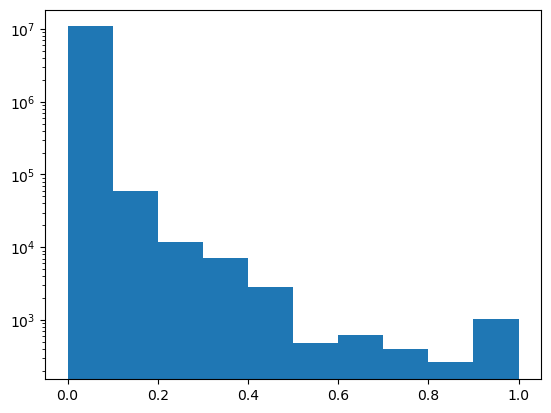

In [41]:
# histogram of connection strengths
plt.hist(inprop.data)
plt.yscale("log")
plt.show()

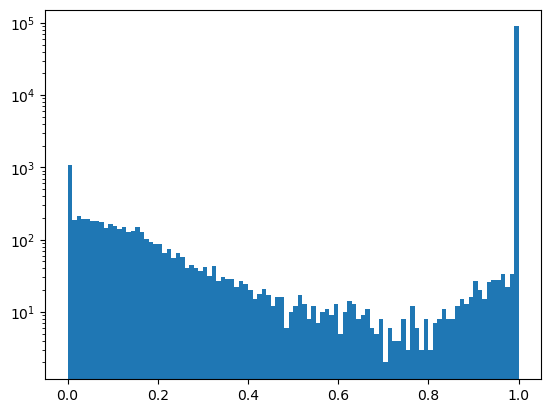

In [42]:
# histogram of column sums
colsums = inprop.sum(axis=0)
plt.hist(colsums.A1, bins=100)
plt.yscale("log")
plt.show()

In [43]:
# how many colsums are around 1?
np.sum(colsums > 0.99)

89240

In [44]:
sp.sparse.save_npz(
    "../data/fafb_right_optic_cb_neuron/fafb_inprop_right_optic_cb_neuron.npz",
    inprop,
)

# save meta

In [45]:
# save to csv, one row is one neuron
meta = meta.loc[
    meta.root_id.isin(nodes),
    [
        "root_id",
        "combined_type",
        "side",
        "top_nt",
        "super_class",
        "cell_class",
        "cell_sub_class",
    ],
]
meta.loc[:, ["idx"]] = meta.root_id.map(nodes_to_idx)
meta.loc[:, ["sign"]] = meta.top_nt.map(nt_value)
meta.rename(columns={"combined_type": "cell_type"}, inplace=True)

# adult, right hemisphere, neuron level, meta information
meta.to_csv(
    f"../data/fafb_right_optic_cb_neuron/fafb_right_optic_cb_neuron_meta.csv"
)

In [46]:
meta

,root_id,cell_type,side,top_nt,super_class,cell_class,cell_sub_class,idx,sign
0,720575940628857210,PS180,left,acetylcholine,central,NaN,NaN,62296,1
1,720575940626838909,CB0924,right,acetylcholine,central,NaN,NaN,54141,1
2,720575940626046919,AVLP429,right,acetylcholine,central,NaN,NaN,51252,1
3,720575940630311383,AVLP151,right,acetylcholine,central,NaN,NaN,67390,1
4,720575940633370649,LC27,right,acetylcholine,visual_projection,NaN,NaN,76899,1
...,...,...,...,...,...,...,...,...,...
139250,720575940618571494,720575940618571494,right,acetylcholine,optic,ME>LO,NaN,24748,1
139251,720575940633170572,CB3823,right,acetylcholine,optic,LO,NaN,76327,1
139252,720575940650339961,CB3848,right,acetylcholine,optic,LO,NaN,93566,1
139253,720575940619997854,720575940619997854,left,acetylcholine,optic,ME>LO,NaN,28779,1
